# Variational Autoencoder (VAE)

In [1]:
import math
import numpy as np
from gymnasium.utils import seeding
import matplotlib.pyplot as plt

CHECKPOINTS = 12
SCALE       = 6.0
TRACK_RAD   = 900/SCALE
TRACK_TURN_RATE = 0.31
TRACK_DETAIL_STEP = 21/SCALE
PLAYFIELD   = 2000/SCALE # Game over boundary

np_random, seed = seeding.np_random(None)

In [2]:
from gym_multi_car_racing import bezier

def get_track(control_points=None, np_random=np_random):
    if control_points is not None:
        a = np.array(control_points)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.1, numpoints=40)
    else:
        a = bezier.get_random_points(n=12, scale=PLAYFIELD, mindst=5, np_random=np_random)
        x, y, _ = bezier.get_bezier_curve(a=a, rad=0.2, edgy=0.1, numpoints=40)

    return a, x, y

In [3]:
def plot_track(track, checkpoints=None):
    # Plot track
    plt.plot(track[:,0], track[:,1], linewidth=9, color=[0.4, 0.4, 0.4])
    plt.plot([track[0,0], track[-1,0]], [track[0,1], track[-1,1]], linewidth=9, color=[0.4, 0.4, 0.4])

    # Plot checkpoints
    if checkpoints is not None:
        for i in range(len(checkpoints)):
            x, y = checkpoints[i,:]
            plt.plot(x, y, 'o', markersize=2, color="tab:orange")
            plt.text(x, y, str(i), fontsize=10, color="black")
    
    plt.xlim(-20,360)
    plt.ylim(-20,360)

    ax = plt.gca()
    ax.set_facecolor(np.array([102, 230, 102])/255.)

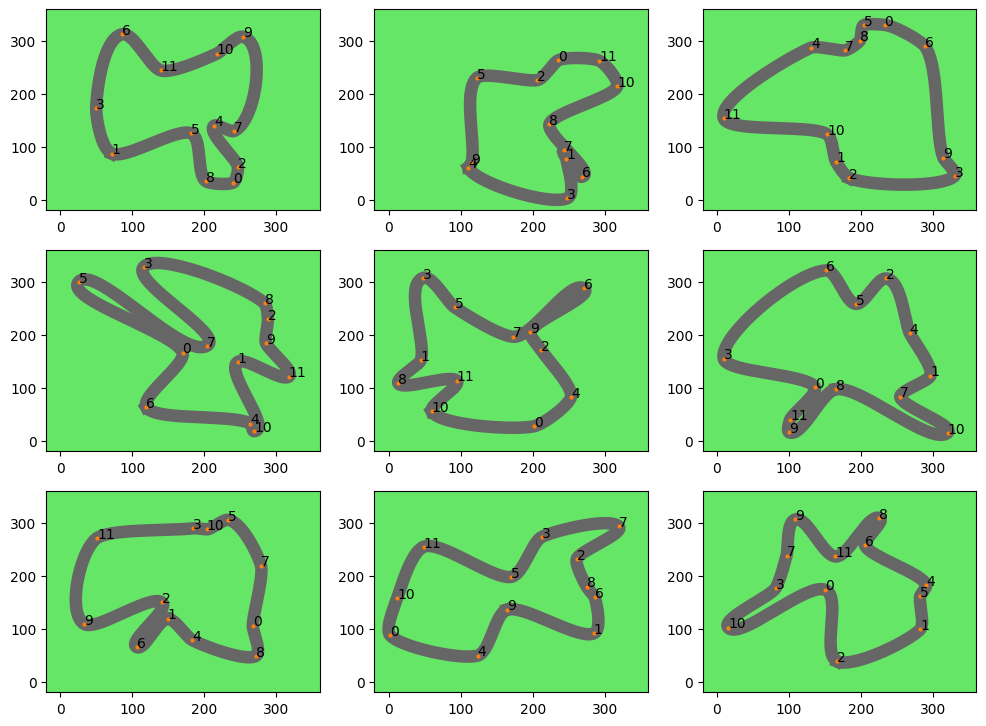

In [4]:
import matplotlib.pyplot as plt

num_plots = 9

width = 12 if num_plots > 3 else 4*num_plots
height = np.ceil(num_plots/3).astype(int)*4

plt.figure(figsize=(width, height))

for i in range(num_plots):

    plt.subplot(height//3, 3, i+1)

    checkpoints, x, y = get_track(np_random=np_random)
    track = np.array([x, y]).T

    # Plot track & checkpoints
    plot_track(track, checkpoints)

## Generate tracks

In [10]:
import cv2

# Create 2d image from track coordinates
def get_image(track, width=48, height=48):
    # Create image
    img = np.zeros((380, 380))
    
    # Shift image so it does not touch the boundary
    min_x = np.min(track[:,0])
    min_y = np.min(track[:,1])
    if min_x < 0:
        track[:,0] += -2*min_x
    if min_y < 0:
        track[:,1] += -2*min_y
    track = np.clip(track, 0, 380-1)
    
    for i in range(len(track)):
        x = track[i,0].astype(int)
        y = track[i,1].astype(int)
        img[x, y] = 1
    # Resize image
    img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
    img = np.ceil(img/2).astype(int)
    # Rotate image
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    return img

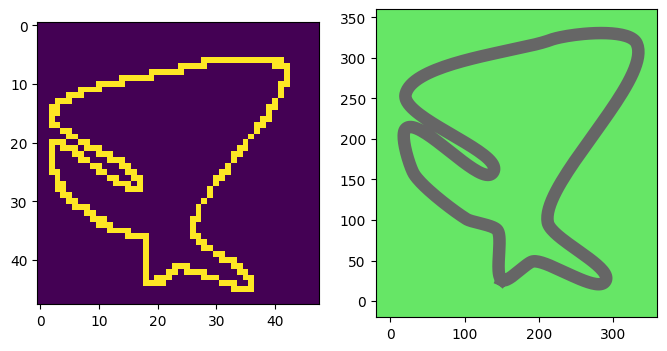

In [11]:
# Generate random track
checkpoints, x, y = get_track(np_random=np_random)
track = np.array([x, y]).T

# Get image from track
img = get_image(track)

# Plot track & image
plt.figure(figsize=(8,4))

# Plot image
plt.subplot(121)
plt.imshow(img)

# Plot track
plt.subplot(122)
plot_track(track)

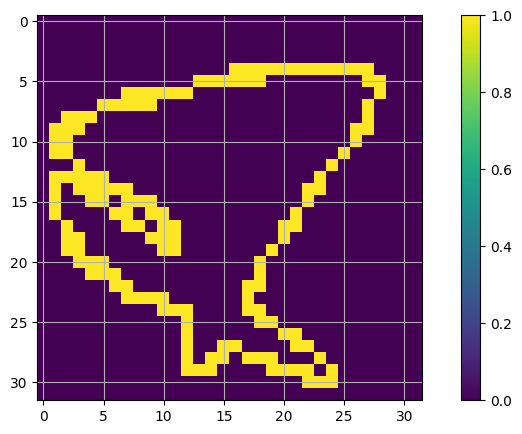

In [12]:
plt.figure(figsize=(10,5))

img_resized = cv2.resize(img.astype(np.float32), dsize=(32, 32), interpolation=cv2.INTER_AREA)
img_resized = np.where(img_resized > 0.3, 1, 0)

plt.imshow(img_resized)
plt.colorbar()
plt.grid()

In [13]:
points = np.array(np.where(img_resized == 1)).T
points = points[:,[1,0]] * 380/32

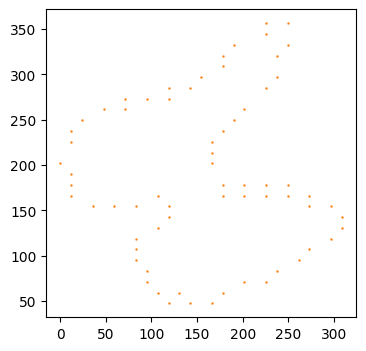

In [9]:
plt.figure(figsize=(4,4))
plt.scatter(points[::2,0], points[::2,1], color="tab:orange", s=0.5)

In [14]:
num_tracks = 10000

X = []

for i in range(num_tracks):
    # Generate random track
    checkpoints, x, y = get_track(np_random=np_random)
    # Get image from track
    X.append(get_image(np.array([x, y]).T))

X = np.array(X).astype(np.float32)
X.shape

(10000, 48, 48)

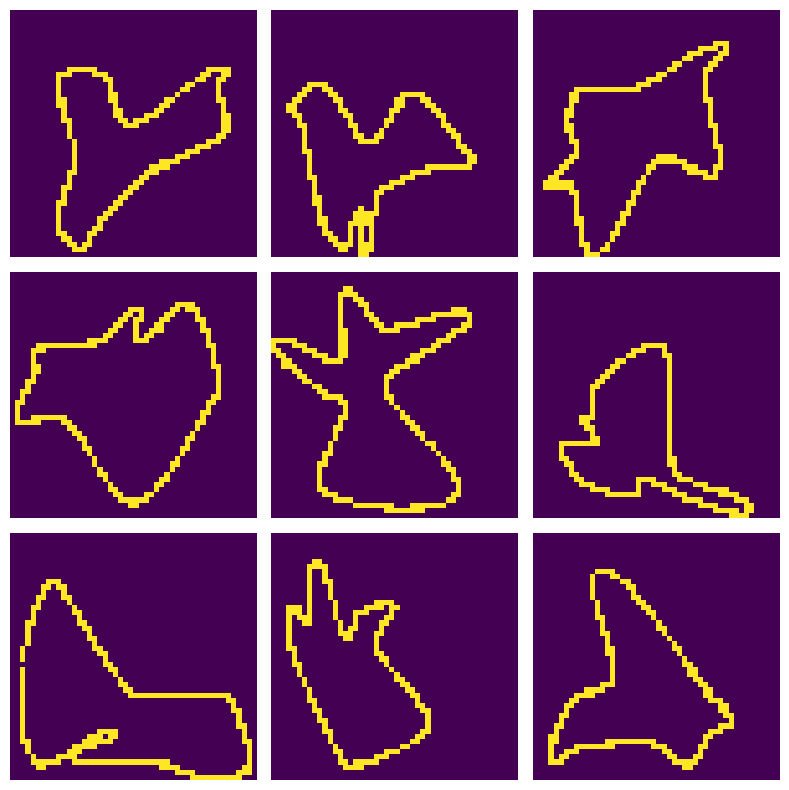

In [18]:
plt.figure(figsize=(8,8))
for i in range(9):
    j = np.random.randint(0, X.shape[0])
    plt.subplot(3,3,i+1)
    plt.imshow(X[j])
    plt.axis('off')
plt.tight_layout()

Create dataset

In [19]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF

class TracksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, tracks):
        self.tracks = tracks

    def __len__(self):
        return len(self.tracks)

    def __getitem__(self, index):
        x = TF.to_tensor(self.tracks[index])
        return x, x

In [20]:
X = np.expand_dims(X, axis=-1)
dataset = TracksDataset(X)

## Train VAE

In [21]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [84]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(48*48, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 48*48)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 48, 48))

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [87]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}", end="\r")
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [88]:
latent_dims = 32
autoencoder = VariationalAutoencoder(latent_dims).to(device) # GPU

data = DataLoader(dataset, batch_size=64, shuffle=True)

autoencoder = train(autoencoder, data, epochs=50)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50


In [57]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], color="tab:blue", s=0.5)

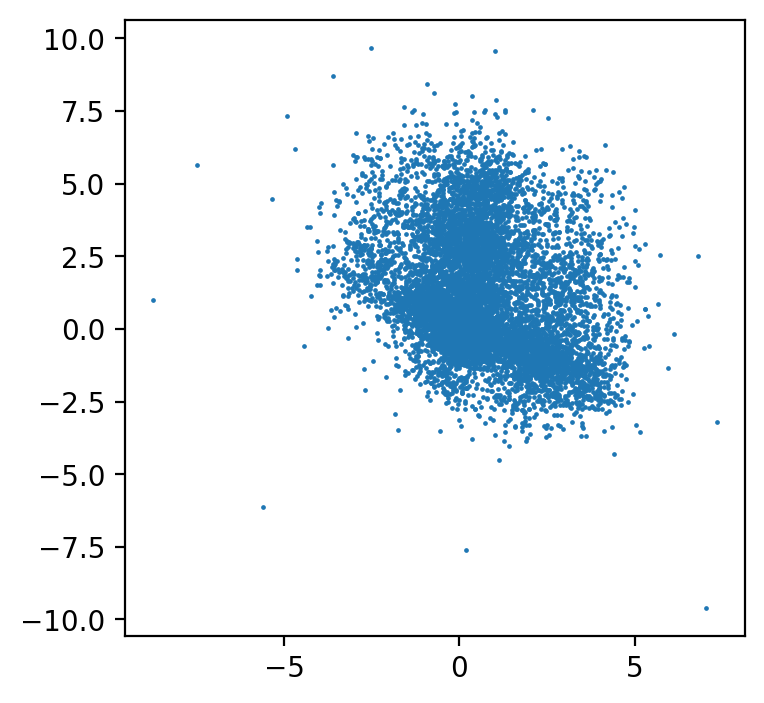

In [58]:
plt.figure(figsize=(4,4))
plot_latent(autoencoder, data)

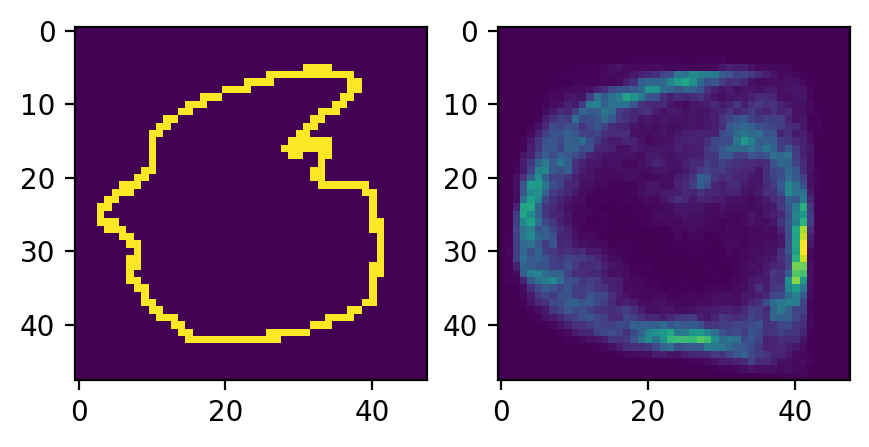

In [100]:
# Plot reconstruction
plt.figure(figsize=(5,4))

j = np.random.randint(0, X.shape[0])
x = torch.from_numpy(X[j]).unsqueeze(0)
x_hat = autoencoder(x.to(device))
x_hat = x_hat.to('cpu').detach().numpy().squeeze()

plt.subplot(121)
plt.imshow(x.squeeze())

plt.subplot(122)
plt.imshow(x_hat)